In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

## Load data

In [2]:
ccf = pd.read_csv('creditcard.csv')

In [3]:
ccf.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
ccf.shape

(284807, 31)

In [5]:
ccf.Class.sum()

492

In [6]:
492/284804*100

0.17275038271934384

#### Initial summary of data

- There are 284,807 observations and 31 variables.
- V1 to V28 are the components from PCA.
- Time represents the seconds elapsed between each transaction and the first transaction in the dataset. Unlikely to be much use except perhaps for some form of seasonality?
- Amount is the transaction amount.
- Class is the response variable. Only 0.17% of the transactions are fraudulent.

## Check and clean data

In [7]:
ccf.isnull().values.any()

False

In [8]:
## Remove time as seem arbitrary

ccf = ccf.drop(['Time'], 1)

In [9]:
ccf['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [10]:
ccf.loc[ccf['Amount'] == 0, 'Amount'].count()

1825

In [11]:
ccf.loc[ccf['Amount'] == 0, 'Class'].value_counts()

0    1798
1      27
Name: Class, dtype: int64

In [12]:
27/1798*100

1.5016685205784204

In [13]:
ccf_zero = ccf.loc[ccf['Amount'] == 0, ]

In [14]:
ccf_zero.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
383,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,-0.059943,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0
514,-1.299837,0.881817,1.452842,-1.293698,-0.025105,-1.170103,0.861610,-0.193934,0.592001,0.241979,...,-0.272563,-0.360853,0.223911,0.598930,-0.397705,0.637141,0.234872,0.021379,0.0,0
534,1.237413,0.512365,0.687746,1.693872,-0.236323,-0.650232,0.118066,-0.230545,-0.808523,0.511284,...,-0.077543,-0.178220,0.038722,0.471218,0.289249,0.871803,-0.066884,0.012986,0.0,0
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.0,1
575,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,-0.371622,...,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.0,0


In [15]:
ccf_no_zero = ccf.loc[~ccf.index.isin(ccf_zero.index), ]

In [16]:
ccf_no_zero.shape

(282982, 30)

#### Data cleaning comments

- Data contains no missing values.
- Data contains 1,825 transactions of amount 0.
- 1.5% of the 0 transactions are fraudulent - a much higher percentage.
- Try modeling but including and excluding these transactions.

## Split data into train and test

In [17]:
x_train, x_test, y_train, y_test = train_test_split(ccf.drop(['Class'], 1), 
                                                    ccf['Class'], 
                                                    test_size=0.3,
                                                    random_state=392,
                                                    stratify = ccf['Class'])

In [18]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(199364, 29)
(85443, 29)
(199364,)
(85443,)


In [19]:
print(y_train.sum())
print(y_test.sum())

344
148


In [20]:
x_train_no0, x_test_no0, y_train_no0, y_test_no0 = train_test_split(ccf_no_zero.drop(['Class'], 1),
                                                                    ccf_no_zero['Class'],
                                                                    test_size=0.3,
                                                                    random_state=392,
                                                                    stratify=ccf_no_zero['Class'])

In [21]:
print(y_train_no0.sum())
print(y_test_no0.sum())

325
140


## Benchmark
Assume all observations are classified as not fraud.

In [22]:
print('True positives =', 0)
print('True negatives =', (y_train == 0).sum())
print('False positives =', 0)
print('False negatives =', (y_train == 1).sum())

print('Sensitivity =', 0 / (0 + (y_train == 1).sum()))
print('Specificity =', (y_train == 0).sum() / ((y_train == 0).sum() + 0))

True positives = 0
True negatives = 199020
False positives = 0
False negatives = 344
Sensitivity = 0.0
Specificity = 1.0


The aim is prioritize finding fraud so the sensitivity needs to be as high as possible. Okay to have some false positives if minimize false negatives, though clearly unfeasible to assume all fraud.

## Define functions
#### Results function

In [23]:
def print_results(table):
    print(table)
    print('True positives =', table.iloc[1, 1])
    print('True negatives =', table.iloc[0, 0])
    print('False positives =', table.iloc[0, 1])
    print('False negatives =', table.iloc[1, 0])
    print('Sensitivity =', table.iloc[1, 1] / (table.iloc[1, 1] + table.iloc[1, 0]))
    print('Specificity =', table.iloc[0,0] / (table.iloc[0, 0] + table.iloc[0, 1]))

In [156]:
def summary_results(dict_of_models):
    results = pd.DataFrame()
    models = []
    true_pos = []
    true_neg = []
    false_pos = []
    false_neg = []
    sens = []
    specs = []
    for model in dict_of_models:
        models.append(model)
        model_table = dict_of_models[model]
        true_pos.append(model_table.iloc[1, 1])
        true_neg.append(model_table.iloc[0, 0])
        false_pos.append(model_table.iloc[0, 1])
        false_neg.append(model_table.iloc[1, 0])
        sens.append(model_table.iloc[1, 1] / (model_table.iloc[1, 1] + model_table.iloc[1, 0]))
        specs.append(model_table.iloc[0, 0] / (model_table.iloc[0, 0] + model_table.iloc[0, 1]))
    results['models'] = models
    results['true_positives'] = true_pos
    results['true_negatives'] = true_neg
    results['false_positives'] = false_pos
    results['false_negatives'] = false_neg
    results['sensitivity'] = sens
    results['specificity'] = specs
    return results

## Logistic Regression
### No regularization - 0.5 cutoff

In [24]:
## Add intercept column
x_train_int = x_train
x_train_int['intercept'] = 1

## Fit model
logit = sm.Logit(y_train, x_train_int)
logit_result = logit.fit()

## Check accuracy on training set
pred_logit_train = logit_result.predict(x_train_int)
pred_y_logit_train = np.where(pred_logit_train < .5, 0, 1)

logit_table = pd.crosstab(y_train, pred_y_logit_train)

print_results(logit_table)

Optimization terminated successfully.
         Current function value: 0.004101
         Iterations 13
col_0       0    1
Class             
0      198987   33
1         137  207
True positives = 207
True negatives = 198987
False positives = 33
False negatives = 137
Sensitivity = 0.6017441860465116
Specificity = 0.9998341875188423


In [113]:
precision_logit, recall_logit, thresholds_logit = precision_recall_curve(y_train, pred_logit_train)
f1_logit = f1_score(y_train, pred_y_logit_train)
auc_logit = auc(recall_logit, precision_logit)
ap_logit = average_precision_score(y_train, pred_logit_train)
print('f1=%.3f auc=%.3f ap=%.3f'% (f1_logit, auc_logit, ap_logit))

f1=0.709 auc=0.754 ap=0.754


### No regularization - 0.0017 cutoff

In [26]:
## Redo but with cutoff equal to proportion of positive class

## Fit model
logit_2 = sm.Logit(y_train, x_train_int)
logit_2_result = logit_2.fit()

## Check accuracy on training set
pred_logit_2_train = logit_2_result.predict(x_train_int)
pred_y_logit_2_train = np.where(pred_logit_2_train < .0017, 0, 1)

logit_2_table = pd.crosstab(y_train, pred_y_logit_2_train)

print_results(logit_2_table)

Optimization terminated successfully.
         Current function value: 0.004101
         Iterations 13
col_0       0     1
Class              
0      190047  8973
1          33   311
True positives = 311
True negatives = 190047
False positives = 8973
False negatives = 33
Sensitivity = 0.9040697674418605
Specificity = 0.9549140789870365


In [114]:
## Check accuracy using Area Under Precision Recall Curve (AUPRC)

## Precision = true positives / (true positives + false positives)
## Recall = true positives / (true positives + false negatives)

precision_logit_2, recall_logit_2, thresholds_logit_2 = precision_recall_curve(y_train, pred_logit_2_train)
f1_logit_2 = f1_score(y_train, pred_y_logit_2_train)
auc_logit_2 = auc(recall_logit_2, precision_logit_2)
ap_logit_2 = average_precision_score(y_train, pred_logit_2_train)
print('f1=%.3f auc=%.3f ap=%.3f'% (f1_logit_2, auc_logit_2, ap_logit_2))

f1=0.065 auc=0.754 ap=0.754


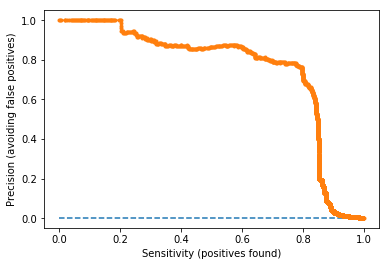

In [115]:
plt.plot([0, 1], [0.0017, 0.0017], linestyle='--')
plt.plot(recall_logit_2, precision_logit_2, marker='.')
plt.xlabel('Sensitivity (positives found)')
plt.ylabel('Precision (avoiding false positives)')
plt.show()

### Try searching for better cutoff

In [30]:
def best_logit_threshold(model, x, y, start, end, step):
    thresholds = []
    sensitivities = []
    specificities = []
    for threshold in np.arange(start, end + step, step):
        pred_y_probs = model.predict(x)
        pred_y_outcome = np.where(pred_y_probs < threshold, 0, 1)
        table = pd.crosstab(y, pred_y_outcome)
        thresholds.append(threshold)
        sensitivities.append(table.iloc[1, 1] / (table.iloc[1, 1] + table.iloc[1, 0]))
        specificities.append(table.iloc[0, 0] / (table.iloc[0, 0] + table.iloc[0, 1]))
        results_df = pd.DataFrame({'threshold': thresholds,
        'sensitivity': sensitivities,
        'specificity': specificities})
        results_df['sum'] = results_df['sensitivity'] + results_df['specificity']
    return results_df

In [31]:
best_logit_threshold(logit_2_result, x_train_int, y_train, 0.0005, 0.009, 0.0005)

,threshold,sensitivity,specificity,sum
0,0.0005,0.965116,0.774374,1.739491
1,0.0010,0.930233,0.904115,1.834348
2,0.0015,0.904070,0.946066,1.850135
3,0.0020,0.892442,0.964727,1.857169
4,0.0025,0.889535,0.974776,1.864311
5,0.0030,0.886628,0.980922,1.867549
6,0.0035,0.877907,0.985182,1.863089
7,0.0040,0.875000,0.988247,1.863247
8,0.0045,0.869186,0.990308,1.859494
9,0.0050,0.869186,0.991604,1.860790


The sensitivity is highest at the lowest threshold, but the specificity is very poor at this level. The best of both occurs at around 0.003.

In [132]:
## Test final model on test set

pred_logit_3_test = logit_2_result.predict(x_test_int)
pred_y_logit_3_test = np.where(pred_logit_3_test <.003, 0, 1)

table_logit_3_test = pd.crosstab(y_test, pred_y_logit_3_test)

print_results(table_logit_3_test)

col_0      0     1
Class             
0      83695  1600
1         12   136
True positives = 136
True negatives = 83695
False positives = 1600
False negatives = 12
Sensitivity = 0.918918918918919
Specificity = 0.9812415733630342


In [143]:
final_models = dict()
final_models['logit_3'] = table_logit_3_test

## Ridge regression - L2 regularization

In [33]:
## Try ridge with default values first to get a sense

ridge = LogisticRegression(solver='liblinear', 
                           penalty='l2', 
                           random_state=392)
ridge.fit(x_train, y_train)
pred_y_ridge_train = ridge.predict(x_train)
table_ridge_train = pd.crosstab(y_train, pred_y_ridge_train)
print_results(table_ridge_train)


col_0       0    1
Class             
0      198987   33
1         137  207
True positives = 207
True negatives = 198987
False positives = 33
False negatives = 137
Sensitivity = 0.6017441860465116
Specificity = 0.9998341875188423


In [34]:
## Grid search the C parameter

c_grid = {'C': np.arange(0.1, 2.1, 0.1)}
ridge_grid = GridSearchCV(estimator=ridge, 
                          param_grid = c_grid,
                          cv=5,
                          verbose=0,
                          scoring='average_precision')

In [35]:
ridge_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=392, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=0)

In [36]:
ridge_grid.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=392, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
ridge_grid.cv_results_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([3.37767901, 3.04820542, 3.9584516 , 3.41093292, 3.35441251,
        3.34827151, 3.58330688, 3.69988499, 3.66092958, 3.38117099,
        3.08976641, 3.55422173, 3.37885184, 3.41039314, 3.67966099,
        3.30953655, 3.67649341, 3.56263804, 3.34189973, 3.39653234]),
 'std_fit_time': array([0.23008236, 0.42226773, 0.91163141, 0.58241529, 0.29140754,
        0.35839435, 0.6222657 , 0.67381371, 0.63041807, 0.32835914,
        0.2527063 , 0.51900235, 0.42342044, 0.20127462, 0.31606241,
        0.43570985, 0.47426379, 0.45851529, 0.49993829, 0.45042755]),
 'mean_score_time': array([0.02546983, 0.02301073, 0.03009796, 0.02208962, 0.02282109,
        0.0229702 , 0.02251859, 0.02365341, 0.02705216, 0.02415853,
        0.02117243, 0.02352371, 0.02255559, 0.02207365, 0.02355981,
        0.02334318, 0.02305923, 0.02184749, 0.02191658, 0.02186937]),
 'std_score_time': array([0.00311927, 0.00182406, 0.00888095, 0.00229575, 0.00171335,
        0.00196044, 0.00169997, 0.001649

In [38]:
## Best estimator was smallest so do new gridsearch for smaller C

c_grid_2 = {'C': np.arange(0.01, 0.11, 0.01)}
ridge_grid_2 = GridSearchCV(estimator=ridge, 
                          param_grid = c_grid_2,
                          cv=5,
                          verbose=0,
                          scoring='average_precision')

In [39]:
ridge_grid_2.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=392, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=0)

In [40]:
ridge_grid_2.best_estimator_

LogisticRegression(C=0.06999999999999999, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=392,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [41]:
ridge_grid_2.cv_results_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([1.73762436, 1.89284334, 2.05412707, 2.29967799, 2.50113468,
        2.70893517, 2.90344605, 2.64886312, 2.77842398, 3.31605511]),
 'std_fit_time': array([0.39539328, 0.16635948, 0.28066621, 0.51324473, 0.46392762,
        0.0916043 , 0.28247455, 0.28536984, 0.16901302, 0.24939569]),
 'mean_score_time': array([0.02203422, 0.02207894, 0.02233801, 0.02312417, 0.02547317,
        0.02549586, 0.02759008, 0.02396159, 0.02347236, 0.02729735]),
 'std_score_time': array([0.00048139, 0.00095109, 0.00149391, 0.00192043, 0.00220765,
        0.00380951, 0.00669325, 0.00172399, 0.00214286, 0.00315876]),
 'param_C': masked_array(data=[0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005,
                    0.06999999999999999, 0.08, 0.09, 0.09999999999999999],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01},
  {'C': 0.02},
  {'C': 0.03},
  

In [42]:
## Retrain model with best C

ridge_2 = LogisticRegression(solver='liblinear',
                            penalty='l2',
                            random_state=392,
                            C=0.07)

ridge_2.fit(x_train, y_train)
pred_y_ridge_2_train = ridge_2.predict(x_train)
table_ridge_2_train = pd.crosstab(y_train, pred_y_ridge_2_train)
print_results(table_ridge_2_train)

col_0       0    1
Class             
0      198992   28
1         144  200
True positives = 200
True negatives = 198992
False positives = 28
False negatives = 144
Sensitivity = 0.5813953488372093
Specificity = 0.999859310622048


In [43]:
ridge_scores = cross_val_score(ridge, x_train, y_train, cv=5, scoring='average_precision')

In [44]:
ridge_2_scores = cross_val_score(ridge_2, x_train, y_train, cv=5, scoring='average_precision')

In [45]:
## Print scores from original and updated ridge models

print('Ridge')
print('Mean =', ridge_scores.mean())
print(ridge_scores)
print('Ridge_2')
print('Mean =', ridge_2_scores.mean())
print(ridge_2_scores)

Ridge
Mean = 0.7443274637158495
[0.71009418 0.75066599 0.75927043 0.81359862 0.6880081 ]
Ridge_2
Mean = 0.7475472494589831
[0.72172145 0.75859083 0.75635594 0.81200203 0.68906601]


In [47]:
## Test data using updated ridge model

pred_y_ridge_2_test = ridge_2.predict(x_test)
table_ridge_2_test = pd.crosstab(y_test, pred_y_ridge_2_test)
print_results(table_ridge_2_test)

col_0      0   1
Class           
0      85286   9
1         55  93
True positives = 93
True negatives = 85286
False positives = 9
False negatives = 55
Sensitivity = 0.6283783783783784
Specificity = 0.9998944838501671


In [144]:
final_models['ridge_2'] = table_ridge_2_test

## Lasso regression
I am not going to try this type of model because the purpose is to identify as many of the fraudulent transactions as possible and this is likely to reduce this accuracy to get a faster model.

## SVM

In [59]:
svm_1 = SVC(random_state=392)
svm_1.fit(x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=392,
  shrinking=True, tol=0.001, verbose=False)

In [60]:
pred_y_svm_1 = svm_1.predict(x_train)

In [61]:
svm_test = SVC()

In [76]:
## Grid search for best gamma and cost

gamma_c_grid = {'C': [0.001, 0.1, 10, 1000], 'gamma': [0.001, 0.1, 10, 1000]}

#list(ParameterGrid(gamma_c_grid))[0]

svm_grid = GridSearchCV(estimator=svm_test,
                        param_grid = gamma_c_grid,
                        cv=5,
                        scoring='average_precision',
                        verbose=10)


In [77]:
## This took approx 2 days to run
## Uncomment at your peril!

#svm_grid.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=0.001, gamma=0.001, score=0.6497632250801306, total=   6.1s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV] ... C=0.001, gamma=0.001, score=0.6843215066698886, total=   6.0s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.2s remaining:    0.0s


[CV] ... C=0.001, gamma=0.001, score=0.6502690063560619, total=   5.7s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.4s remaining:    0.0s


[CV] .... C=0.001, gamma=0.001, score=0.603074719505198, total=   5.7s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   40.3s remaining:    0.0s


[CV] .... C=0.001, gamma=0.001, score=0.698280691286174, total=   5.7s
[CV] C=0.001, gamma=0.1 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.0s remaining:    0.0s


[CV] ..... C=0.001, gamma=0.1, score=0.7284243506985816, total=   6.3s
[CV] C=0.001, gamma=0.1 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.1, score=0.7207795218011596, total=   6.3s
[CV] C=0.001, gamma=0.1 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.1, score=0.6792065917665335, total=   6.7s
[CV] C=0.001, gamma=0.1 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.1, score=0.6294883706836776, total=   6.5s
[CV] C=0.001, gamma=0.1 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV] ..... C=0.001, gamma=0.1, score=0.6429584555211062, total=   6.2s
[CV] C=0.001, gamma=10 ...............................................
[CV] ...... C=0.001, gamma=10, score=0.2477517454916117, total=   8.3s
[CV] C=0.001, gamma=10 ...............................................
[CV] ...... C=0.001, gamma=10, score=0.1440711503068679, total=   8.8s
[CV] C=0.001, gamma=10 ...............................................
[CV] ...... C=0.001, gamma=10, score=0.2188167458387323, total=   8.4s
[CV] C=0.001, gamma=10 ...............................................
[CV] ..... C=0.001, gamma=10, score=0.12893384885684375, total=   8.9s
[CV] C=0.001, gamma=10 ...............................................
[CV] ..... C=0.001, gamma=10, score=0.16965854960060495, total=   8.9s
[CV] C=0.001, gamma=1000 .............................................
[CV] ... C=0.001, gamma=1000, score=0.04513509531163877, total=   7.3s
[CV] C=0.001, gamma=1000 .............................................
[CV] .

[CV] ...... C=1000, gamma=0.1, score=0.5057103705844724, total=21.5min
[CV] C=1000, gamma=0.1 ...............................................
[CV] ...... C=1000, gamma=0.1, score=0.4068618341855855, total=20.6min
[CV] C=1000, gamma=0.1 ...............................................
[CV] ...... C=1000, gamma=0.1, score=0.3868884905397954, total=29.5min
[CV] C=1000, gamma=10 ................................................
[CV] ....... C=1000, gamma=10, score=0.2612180739819179, total=59.8min
[CV] C=1000, gamma=10 ................................................
[CV] ....... C=1000, gamma=10, score=0.1288766402950645, total=62.2min
[CV] C=1000, gamma=10 ................................................
[CV] ...... C=1000, gamma=10, score=0.22024400046108872, total=65.6min
[CV] C=1000, gamma=10 ................................................
[CV] ...... C=1000, gamma=10, score=0.12941066219035138, total=58.7min
[CV] C=1000, gamma=10 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 1824.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.1, 10, 1000], 'gamma': [0.001, 0.1, 10, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=10)

In [78]:
svm_grid.best_params_

{'C': 10, 'gamma': 0.001}

In [159]:
## It says C=10, gamma = 0.001

In [79]:
svm_grid.cv_results_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([   4.80634828,    5.24839916,    7.48941479,    7.39845738,
         437.0103704 ,  612.07589846,  573.46160698,  426.74389544,
          27.22044768, 1138.92231126, 3500.13498344, 2190.34356165,
          36.0904736 , 1320.90620022, 3615.83455925, 2476.39578581]),
 'std_fit_time': array([1.56158862e-01, 1.84697099e-01, 2.13974943e-01, 1.22168599e+00,
        2.08337177e+02, 5.86535356e+01, 1.04725195e+02, 2.49925585e+01,
        2.24917085e+00, 2.55177895e+01, 1.80068848e+02, 2.72830854e+01,
        4.77253592e+00, 2.02150445e+02, 3.28029572e+02, 4.22606294e+02]),
 'mean_score_time': array([  1.04397001,   1.139464  ,   1.17941804,   1.14639287,
          2.21277194,  38.06273465,  58.15876327,  45.07555666,
          1.83386159,  50.75950675, 224.31034989, 192.2588932 ,
          0.9329278 ,  48.14598632, 240.80545216, 193.99472117]),
 'std_score_time': array([3.67327535e-02, 2.32790818e-02, 5.79756511e-02, 1.63460145e-01,
        4.77937310e-02, 4.87094270e+

In [86]:
svm_grid.cv_results_['mean_test_score'].reshape(4, 4)

array([[0.65714162, 0.68017164, 0.18184647, 0.06849105],
       [0.69166539, 0.54496883, 0.18494154, 0.06855177],
       [0.77241829, 0.48504375, 0.1826671 , 0.07443212],
       [0.71814635, 0.4657331 , 0.18266707, 0.07443212]])

In [87]:
svm_results = pd.DataFrame(
    data=svm_grid.cv_results_['mean_test_score'].reshape(4, 4),
    columns=['gamma0_001', 'gamma0_1', 'gamma10', 'gamma1000'],
    index=['C0_001', 'C0_1', 'C10', 'C1000']
)

svm_results

,gamma0_001,gamma0_1,gamma10,gamma1000
C0_001,0.657142,0.680172,0.181846,0.068491
C0_1,0.691665,0.544969,0.184942,0.068552
C10,0.772418,0.485044,0.182667,0.074432
C1000,0.718146,0.465733,0.182667,0.074432


In [91]:
## Grid search for improved cost for gamma = 0.001

svm_3 = SVC(random_state=392, gamma=0.001)

c_grid_3 = {'C': [1, 10, 50, 100]}

#list(ParameterGrid(gamma_c_grid))[0]

svm_3_grid = GridSearchCV(estimator=svm_3,
                        param_grid = c_grid_3,
                        cv=5,
                        scoring='average_precision',
                        verbose=10,
                         n_jobs=2)

In [93]:
svm_3_grid.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   52.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 12.9min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 16.3min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 18.0min
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 19.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 19.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=392, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'C': [1, 10, 50, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='average_precision',
       verbose=10)

In [103]:
svm_3_grid.best_params_

{'C': 50}

In [104]:
svm_3_grid.cv_results_

{'mean_fit_time': array([353.11130433,  30.40843024,  19.50908203,  22.42353144]),
 'std_fit_time': array([265.09691858,   3.032128  ,   2.28867347,   3.53267575]),
 'mean_score_time': array([2.44607282, 2.17240744, 1.06291895, 1.10524659]),
 'std_score_time': array([0.16899079, 0.12701307, 0.05571986, 0.05148165]),
 'param_C': masked_array(data=[1, 10, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1}, {'C': 10}, {'C': 50}, {'C': 100}],
 'split0_test_score': array([0.71144109, 0.7439686 , 0.77161186, 0.75238456]),
 'split1_test_score': array([0.70099704, 0.74524051, 0.75991273, 0.75703785]),
 'split2_test_score': array([0.74282888, 0.80451972, 0.79799506, 0.78325256]),
 'split3_test_score': array([0.76494524, 0.80795987, 0.80424284, 0.78767044]),
 'split4_test_score': array([0.74623155, 0.76040248, 0.74830239, 0.72880169]),
 'mean_test_score': array([0.73328869, 0.77241829, 0.77641312, 0.76182958]),
 'st

In [107]:
## Retrain on best parameters

## Test on test set for comparison to other models

svm_4 = SVC(random_state = 392, C=50, gamma=0.001)
svm_4.fit(x_train, y_train)
y_pred_svm_4 = svm_4.predict(x_test)
table_svm_4_test = pd.crosstab(y_test, y_pred_svm_4)
print_results(table_svm_4_test)

col_0      0    1
Class            
0      85287    8
1         34  114
True positives = 114
True negatives = 85287
False positives = 8
False negatives = 34
Sensitivity = 0.7702702702702703
Specificity = 0.9999062078668152


In [145]:
final_models['svm_4'] = table_svm_4_test

## KNN

In [99]:
knn_1 = KNeighborsClassifier()

n_weight_grid_1 = {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}

knn_1_grid = GridSearchCV(estimator=knn_1,
                         param_grid = n_weight_grid_1,
                         cv=5,
                         scoring='average_precision', 
                         verbose=10,
                         n_jobs=1)

In [100]:
knn_1_grid.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=3, weights=uniform, score=0.7379237209265016, total=  33.5s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.655385937202625, total=  30.6s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.7min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.6855178461988348, total=  36.3s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.2min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.6055221503134315, total=  33.1s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.5min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.6954893126033999, total=  33.5s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.0min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=0.7737990963471055, total=  32.4s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 14.4min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=0.6737796784929289, total=  31.1s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 17.0min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=0.7069535761623345, total=  32.8s
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 19.8min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=0.6242495965901359, total= 2.8min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 24.3min remaining:    0.0s


[CV]  n_neighbors=3, weights=distance, score=0.7167182483037509, total=  37.6s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.7258460065508769, total=  33.8s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6585924492062369, total=  41.7s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6814653350005783, total=  44.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6341746657321272, total=  40.7s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6899697134593945, total=  40.4s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.7630935255696485, total=  37.7s
[CV] n_neighbors=5, weight

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 94.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=10)

In [101]:
knn_1_grid.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

In [102]:
knn_1_grid.cv_results_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([0.63130302, 0.67151294, 0.62936387, 0.61389456, 0.64162002,
        0.69184804]),
 'std_fit_time': array([0.04316171, 0.04513785, 0.05869786, 0.03306693, 0.14315167,
        0.10888712]),
 'mean_score_time': array([32.73997602, 59.58899961, 39.49200521, 37.59378581, 48.37414436,
        45.21985936]),
 'std_score_time': array([ 1.79765952, 53.68606934,  3.34827961,  3.33133593,  6.43986566,
         2.36656492]),
 'param_n_neighbors': masked_array(data=[3, 3, 5, 5, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                    'uniform', 'distance'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3, 'weights': 'uniform'},
  {'n_neighbors': 3, 'weights': 'distance'},
  {'n_neighbors': 5, 'weights': 'uniform

In [108]:
## Retrain on best params and test on test set for comparison

knn_2 = KNeighborsClassifier(n_neighbors =5 , weights='distance')
knn_2.fit(x_train, y_train)
pred_y_knn_2 = knn_2.predict(x_test)
table_knn_2_test = pd.crosstab(y_test, pred_y_knn_2)
print_results(table_knn_2_test)

col_0      0   1
Class           
0      85291   4
1         49  99
True positives = 99
True negatives = 85291
False positives = 4
False negatives = 49
Sensitivity = 0.668918918918919
Specificity = 0.9999531039334076


In [146]:
final_models['knn_2'] = table_knn_2_test

## Random Forest

In [116]:
rfc_1 = RandomForestClassifier(n_estimators=10,
                               random_state=392,
                               verbose=2,
                               n_jobs=2)


In [117]:
rfc_1_params = {'max_depth': [5, 10, 30], 'max_features': [2, 5, 10]}

rfc_1_grid = GridSearchCV(rfc_1,
                         rfc_1_params,
                         scoring='average_precision',
                         cv=5,
                         verbose=10,
                         n_jobs=2)

In [118]:
rfc_1_grid.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   16.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   32.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   50.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:  3.0min finished
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    6.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=2,
            oob_score=False, random_state=392, verbose=2, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'max_depth': [5, 10, 30], 'max_features': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=10)

In [119]:
rfc_1_grid.best_params_

{'max_depth': 10, 'max_features': 5}

In [122]:
rfc_1_grid.cv_results_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([ 1.98929162,  3.71066256,  6.60944891,  2.90821157,  6.95738678,
        12.64408236,  3.73599405,  9.11913567, 17.707236  ]),
 'std_fit_time': array([0.08585694, 0.21263038, 0.38901156, 0.18392263, 0.39752634,
        1.14144236, 0.09954115, 0.65687826, 2.17830605]),
 'mean_score_time': array([0.12434034, 0.12443404, 0.12435403, 0.13279471, 0.12615361,
        0.12354245, 0.11877818, 0.12283287, 0.12195759]),
 'std_score_time': array([0.00329677, 0.00303242, 0.0027887 , 0.00508212, 0.00342836,
        0.00295814, 0.00179566, 0.00189039, 0.00126607]),
 'param_max_depth': masked_array(data=[5, 5, 5, 10, 10, 10, 30, 30, 30],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[2, 5, 10, 2, 5, 10, 2, 5, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fil

In [123]:
rfc_1_results = pd.DataFrame(
    data=rfc_1_grid.cv_results_['mean_test_score'].reshape(3, 3),
    columns=['maxfeat2', 'maxfeat5', 'maxfeat10'],
    index=['maxdepth5', 'maxdepth10', 'maxdepth30']
)

rfc_1_results

,maxfeat2,maxfeat5,maxfeat10
maxdepth5,0.776456,0.796453,0.797290
maxdepth10,0.798919,0.815387,0.809289
maxdepth30,0.799321,0.805805,0.801738


In [124]:
## Retrain with best parameters and test on test set

rfc_2 = RandomForestClassifier(n_estimators=10,
                               random_state=392,
                               max_depth=10,
                               max_features=5)

rfc_2.fit(x_train, y_train)
pred_y_rfc_2 = rfc_2.predict(x_test)
table_rfc_2_test = pd.crosstab(y_test, pred_y_rfc_2)
print_results(table_rfc_2_test)

col_0      0    1
Class            
0      85289    6
1         30  118
True positives = 118
True negatives = 85289
False positives = 6
False negatives = 30
Sensitivity = 0.7972972972972973
Specificity = 0.9999296559001114


In [147]:
final_models['rfc_2'] = table_rfc_2_test

## Gradient Boost

In [120]:
gbc_1 = GradientBoostingClassifier(loss='deviance',
                                 max_depth=5,
                                random_state=392,
                                verbose=2)


In [126]:
gbc_1_params = {'loss': ['deviance', 'exponential'], 'max_depth': [5, 10, 20]}

gbc_1_grid = GridSearchCV(gbc_1,
                          gbc_1_params,
                          scoring='average_precision',
                          cv=5,
                          verbose=10,
                          n_jobs=2)

In [127]:
gbc_1_grid.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  9.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 19.9min
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 48.4min finished


      Iter       Train Loss   Remaining Time 
         1           0.0773            2.06m
         2           0.0720            2.08m
         3           0.0675            2.04m
         4           0.0630            2.03m
         5           0.0592            2.00m
         6           0.0561            2.05m
         7           0.0529            2.06m
         8           0.0502            2.08m
         9           0.0478            2.08m
        10           0.0454            2.09m
        11           0.0437            2.07m
        12           0.0420            2.06m
        13           0.0403            2.04m
        14           0.0390            2.02m
        15           0.0377            2.01m
        16           0.0365            1.99m
        17           0.0355            1.98m
        18           0.0346            1.95m
        19           0.0338            1.93m
        20           0.0330            1.92m
        21           0.0324            1.89m
        2

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=2, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'loss': ['deviance', 'exponential'], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=10)

In [128]:
gbc_1_grid.best_params_

{'loss': 'exponential', 'max_depth': 5}

In [129]:
gbc_1_grid.cv_results_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([136.4306828 ,  79.72978301,   7.86400566, 141.36643181,
        341.85882778, 418.2566916 ]),
 'std_fit_time': array([ 5.98598527, 35.9459582 ,  0.37235557,  1.76928766,  8.27855583,
        36.01976936]),
 'mean_score_time': array([0.07197108, 0.05387154, 0.02344255, 0.08625913, 0.13936648,
        0.17837415]),
 'std_score_time': array([0.00784596, 0.01050749, 0.00331524, 0.00513458, 0.00842296,
        0.00658454]),
 'param_loss': masked_array(data=['deviance', 'deviance', 'deviance', 'exponential',
                    'exponential', 'exponential'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 10, 20, 5, 10, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'loss': 'deviance', 'max_depth': 5},
  {'loss': 'deviance', 'max_depth': 10},
  {'loss': 'deviance', 'max_depth

In [130]:
## Retrain with best parameters and test on test set

gbc_2 = GradientBoostingClassifier(loss='exponential',
                                   random_state=392,
                                   max_depth=5)

gbc_2.fit(x_train, y_train)
pred_y_gbc_2 = gbc_2.predict(x_test)
table_gbc_2_test = pd.crosstab(y_test, pred_y_gbc_2)
print_results(table_gbc_2_test)

col_0      0    1
Class            
0      85290    5
1         28  120
True positives = 120
True negatives = 85290
False positives = 5
False negatives = 28
Sensitivity = 0.8108108108108109
Specificity = 0.9999413799167595


In [148]:
final_models['gbc_2'] = table_gbc_2_test

## Compare model performances

In [157]:
summary_results(final_models)

,models,true_positives,true_negatives,false_positives,false_negatives,sensitivity,specificity
0,logit_3,136,83695,1600,12,0.918919,0.981242
1,ridge_2,93,85286,9,55,0.628378,0.999894
2,svm_4,114,85287,8,34,0.770270,0.999906
3,knn_2,99,85291,4,49,0.668919,0.999953
4,rfc_2,118,85289,6,30,0.797297,0.999930
5,gbc_2,120,85290,5,28,0.810811,0.999941


In [158]:
## Gradient Boosting model finds the most true positives
## for the lowest level of false positives

## If want to get most true positive can use Logistic Regression
## but get very large number of false positives